In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
import os
import subprocess
import json
import sys


VCF input file: gz file of vcf compressed by bgzip needed

In [3]:
#file names, should try to automate more
VCF_FILE_NAME = 'ERR6635423_q20.recode.vcf.gz' #this needs to be changed as well 
VCF_PATH = '../../../data/processed/freebayesVCF'
VCF_FILE_PATH = os.path.join(VCF_PATH, VCF_FILE_NAME)
JSON_FILE_PATH = os.path.join(VCF_PATH, 'results/ERR6635423.results.json') #for the time being, change the file names here

In [4]:
#tried to recognise whether if the vcf file is in gz format, if not, compress it
# import re

# if re.match('*vcf$',VCF_FILE_NAME):
#     print('Please input .vcf.gz format file compresed using bgzip')


In [5]:
#***for the time being, this can't be run***

#running tb-profiler to identify drug resistance for the sample
#need to be run in tb-profiler environment, somehow failed to download tb-profiler in ml-s7, so far this part is run out side python in bash

# subprocess.call(['tb-profiler', 'vcf_profile', VCF_FILE_PATH])


In [6]:
#read in the drug resistance labeled file generated from tb-profiler
with open(JSON_FILE_PATH, 'r') as f:
    json_labelling = json.load(f)

In [7]:
#get the reference read and alternative read count, changing environment is somehow not working in python
env_command = 'eval "$(conda shell.bash hook)"; conda activate tb-profiler'
subprocess.run(env_command, shell=True)

with open('ROAO_proportion.csv', 'w') as f:
    subprocess.run(['bcftools', 'query', '-f', '[%POS,%RO,%AO\n]', VCF_FILE_PATH], shell=False, stdout=f, text=True)


Could not find conda environment: tb-profiler
You can list all discoverable environments with `conda info --envs`.



In [8]:
#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
import csv

f = open('ROAO_proportion.csv')

data = []
num_col=0
for line in f:
    data_line = line.rstrip().split('\n')
    data_line = data_line[0].split(',')
    data_line = [int(i) for i in data_line]
    if len(data_line) > num_col:
        num_col = len(data_line)
    data.append(data_line)

print(num_col) #outputing the length of column in the dataframe
num_RO = num_col - 1
print(num_RO)


4
3


In [9]:
#this is to show the position of each variant a being read from the json file --- doesn't need to be run

# for reads in json_labelling['dr_variants']:
#     print(reads['genome_pos'])
#     for i in reads['drugs']:
#         print(i['drug'])

# for reads in json_labelling['other_variants']:
#     print(reads['genome_pos'])
#     print(reads['gene_associated_drugs'])

In [10]:
#reading csv as pandas dataframe and create a numpy array version of it
df = pd.read_csv('ROAO_proportion.csv', names=range(num_col)) #doesn't include the 4th colum
df.fillna(value=0, inplace=True)
df[num_col] = None #create 4th column here as a empty column of zero, this column is for the drug resistance info
df_np = df.to_numpy()



In [11]:

#numpy array and json file compared against each other in terms of genome position and 
#the drug resistance info is added on to the 4th column of the numpy array if there is a match in genome position
for ind, pos in enumerate(df_np[:,0]): 
    for reads in json_labelling['dr_variants']:
        if pos == reads['genome_pos']:
            # print('hit: ', pos)
            for i in reads['drugs']:
                df_np[ind, 4] = [i['drug']]

#json_labelling['other_variants'] contain variant in region of variants that are responsible for drug resistance, but these variants are no the variants responsible for resistance even though they are in the region where resistance variants are found
# for ind, pos in enumerate(df_np[:,0]):
#     for reads in json_labelling['other_variants']:
#         if pos == reads['genome_pos']:
#             # print('hit: ', pos)
#             df_np[ind, 4] = reads['gene_associated_drugs']


In [12]:
df_np

array([[1302, 77, 349, 0.0, None],
       [1849, 380, 86, 0.0, None],
       [1977, 0, 480, 0.0, None],
       ...,
       [4408920, 0, 281, 66.0, None],
       [4410386, 112, 350, 0.0, None],
       [4411016, 108, 310, 0.0, None]], dtype=object)

In [13]:
#training gaussianMixture Model

from sklearn.mixture import GaussianMixture

model_input = df_np[:,1:num_col]
gm = GaussianMixture(n_components=num_RO, random_state=0).fit(model_input)

In [14]:
#create number of strain number of object in a dictionary
resistance_dict = {}

for x in range(1,num_RO+1):
    resistance_dict['strain'+ str(x)] = []

# resistance_dict

In [15]:
# np.set_printoptions(threshold=sys.maxsize)
# df_np


In [53]:
#reads are assigned to different strains according to their ROAO by the gaussianMixture model
#and added to the corresponding strain item in dictionary
probs_array = []

for x in df_np:
    if x[num_col] != None:
        output = gm.predict([x[1:num_col]])
        probs = gm.predict_proba([x[1:num_col]])
        print(x[num_col], 'probs: ', probs.round(3))
        resistance = np.array(x[num_col])
        insert = np.append(resistance, probs.round(3))
        probs_array.append(insert)
        print(insert)
        print(type(probs_array))

        for i in range(1,num_RO+1):
            if output == [i-1]: 
                # if x[num_col] in resistance_dict['strain'+ str(i)]:
                #     continue
                resistance_dict['strain'+ str(i)].extend(x[num_col])
                # print(x[num_col], 'added')

np.array(probs_array)

for x in df_np: #this bit has to be another separate for loop because it add the resistance to all strain that are not empty, strain must be added first to determine if they are truely empty or not
    if x[num_col] != None:
        for i in range(1,num_RO+1):
            if output == [i-1]:
                if max(x[1:num_col])/sum(x[1:num_col]) >= 0.99: #calculating frequency if the frequenct >= 0.99 we could say that this resistance exist in all strains
                    for k, v in resistance_dict.items():
                        if len(v) != 0: #if this is not a empty strain
                            resistance_dict['strain'+ str(i)].extend(x[num_col]) #

                




['rifampicin'] probs:  [[0. 0. 1.]]
['rifampicin' '0.0' '0.0' '1.0']
<class 'list'>
['rifampicin'] probs:  [[0.    0.999 0.001]]
['rifampicin' '0.0' '0.999' '0.001']
<class 'list'>
['streptomycin'] probs:  [[0. 0. 1.]]
['streptomycin' '0.0' '0.0' '1.0']
<class 'list'>
['capreomycin'] probs:  [[0. 0. 1.]]
['capreomycin' '0.0' '0.0' '1.0']
<class 'list'>
['isoniazid'] probs:  [[0. 1. 0.]]
['isoniazid' '0.0' '1.0' '0.0']
<class 'list'>
['ethambutol'] probs:  [[0. 0. 1.]]
['ethambutol' '0.0' '0.0' '1.0']
<class 'list'>
['ethionamide'] probs:  [[0. 0. 1.]]
['ethionamide' '0.0' '0.0' '1.0']
<class 'list'>


/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (ren

array([['rifampicin', '0.0', '0.0', '1.0'],
       ['rifampicin', '0.0', '0.999', '0.001'],
       ['streptomycin', '0.0', '0.0', '1.0'],
       ['capreomycin', '0.0', '0.0', '1.0'],
       ['isoniazid', '0.0', '1.0', '0.0'],
       ['ethambutol', '0.0', '0.0', '1.0'],
       ['ethionamide', '0.0', '0.0', '1.0']], dtype='<U32')

In [22]:
df_np

array([[1302, 77, 349, 0.0, None],
       [1849, 380, 86, 0.0, None],
       [1977, 0, 480, 0.0, None],
       ...,
       [4408920, 0, 281, 66.0, None],
       [4410386, 112, 350, 0.0, None],
       [4411016, 108, 310, 0.0, None]], dtype=object)

In [61]:
#remove ducplicate items and show the dictionary as a df
for x in range(1,num_RO+1):
    resistance_dict['strain'+ str(x)] = np.unique(resistance_dict['strain'+ str(x)])

pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in resistance_dict.items() ]))

,strain1,strain2,strain3
0,NaN,isoniazid,capreomycin
1,NaN,rifampicin,ethambutol
2,NaN,NaN,ethionamide
3,NaN,NaN,isoniazid
4,NaN,NaN,rifampicin
5,NaN,NaN,streptomycin


In [56]:
pd.DataFrame(probs_array)

,0,1,2,3
0,rifampicin,0.0,0.0,1.0
1,rifampicin,0.0,0.999,0.001
2,streptomycin,0.0,0.0,1.0
3,capreomycin,0.0,0.0,1.0
4,isoniazid,0.0,1.0,0.0
5,ethambutol,0.0,0.0,1.0
6,ethionamide,0.0,0.0,1.0


<BarContainer object of 1171 artists>

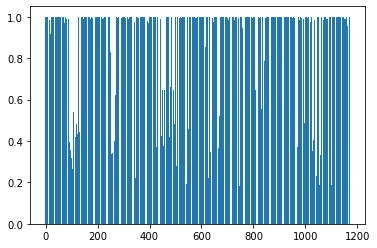

In [262]:
#frequency graph assuming that there is only two strains
df_2component = pd.read_csv('ROAO_proportion.csv', names=range(3))
df_2component['proportion'] = df_2component[2]/(df_2component[1]+df_2component[2]) # alt/(ref+alt)

fig, ax= plt.subplots()
ax.bar(np.arange(len(df_2component[2])),df_2component['proportion'])
